# Data analysis of client sessions of the service 'SberAutopodpiska'


**Goals and objectives of the notebook**:
* familiarity with the data;
* assessment of the purity and completeness of the data;
* preparation of a plan for data formatting;
* evaluation of data distributions and their relationships.


## Preparation

### Import libraries

In [1]:
import sys
import warnings

from pathlib import Path
from typing import Sequence, Union

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from additional_data import (
    social_media_sources, target_events, moscow_region_cities, organic_mediums, 
    russian_holidays, get_distance_from_moscow, big_cities, missing_values
)

### Notebook settings

In [2]:
sns.set()
plt.rc('figure', figsize=(18, 6))
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

### Functions 


In [4]:
def count_missings(data: pd.Series) -> int:
    """
    Returns the number of missing values in pd.Series.
    """

    return data.isin(missing_values).sum()

In [5]:
def as_percent(x: float) -> str:
    """
    Used to convert a share to a percentage (as a string).
    """
    
    return f'{x:0.2%}'

In [6]:
def replace_rare(data: pd.Series, tolerance: float = 0.05) -> pd.Series:
    """
    Replaces rare values in the column with 'rare_other'.
    Rare values are values whose occurrence fraction does not exceed `tolerance`. 
    Also fills gaps with the value '(nan)'.
    """

    data = data.copy()

    value_counts = data.value_counts(dropna=False)
    rare_values = value_counts[value_counts < (len(data) * tolerance)]
    rare_values = rare_values.index.tolist()
    
    data[data.isin(rare_values)] = 'rare_other'
    return data.fillna('(nan)')

In [7]:
def target_percentage(
    data:pd.DataFrame,
    column: str,
    index_name: str = '',
    only_target: bool = False,
    sort: bool = True,
    percent: bool = True
) -> Union[pd.DataFrame, pd.Series]:
    """
    Returns the percentage of target actions in a convenient form (`target`==1)
    by the values of the given `column`.
    """

    # column names
    count = 'Number of objects'
    ratio = 'Percentage of the total'
    target = 'Percentage of target actions'

    # split by value
    groupby = data.groupby(column)
    
    # calculation of the number of objects and the share of target actions
    result = pd.DataFrame(index=groupby.groups)
    result[count] = groupby[column].count()
    result[ratio] = result[count] / len(data)
    result[target] = groupby['target'].sum() / result[count]
    
    # output table formatting
    result.index.name = index_name or column
    if sort: result = result.sort_values(target, ascending=False)
    if percent:
        result[target] = result[target].apply(as_percent)
        result[ratio] = result[ratio].apply(as_percent)
    
    # return results
    if only_target:
        return result[target].rename('target_percentage')
    
    return result

### Data loading

In [8]:
sessions = pd.read_csv('data/ga_sessions.csv', dtype={"client_id": "string"})
hits = pd.read_csv('data/ga_hits.csv', usecols=['session_id', 'event_action'])

## `hits` analysis

### General information

The `hits` table is a set of events within one visit to the 'SberAutosubscription' site.

The number of rows in the table is 15,726,470 and the number of columns is 11. There are no duplicates.

Useful columns in this table are `event_action`, which contains the target variable, and `session_id`, which helps determine in which particular session the event occurred. The rest of the columns cannot be used to avoid data leakage in the simulation. 


In [9]:
hits.head()

,session_id,event_action
0,5639623078712724064.1640254056.1640254056,quiz_show
1,7750352294969115059.1640271109.1640271109,quiz_show
2,885342191847998240.1640235807.1640235807,quiz_show
3,142526202120934167.1640211014.1640211014,quiz_show
4,3450086108837475701.1640265078.1640265078,quiz_show


In [10]:
hits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 2 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   session_id    object
 1   event_action  object
dtypes: object(2)
memory usage: 240.0+ MB


In [11]:
print('Number of duplicates in hits:', {hits.duplicated().sum()})

Number of duplicates in hits: {9265924}


### `session_id` - visit ID  

There are no empty values in the column.
The number of events per session varies from 1 to 768, but most sessions end with 1 - 2 events.

In [12]:
missings = count_missings(hits['session_id'])
print('Number of empty values in `session_id`:', missings)

Number of empty values in `session_id`: 0


In [13]:
event_counts = hits['session_id'].value_counts()
event_counts.name = 'event_counts'
event_counts

5442565791571325612.1632449195.1632449195    768
6568868914238486437.1632270313.1632270313    678
5959671972744778783.1632490527.1632490600    548
7452598043578978502.1632358598.1632358598    514
3070792010704358528.1629752408.1629752408    498
                                            ... 
4570994095441102117.1630324006.1630324006      1
768506153535315810.1630314342.1630314342       1
5517253735248338264.1630315080.1630315080      1
4054272189286640867.1630334209.1630334209      1
5381267721977892188.1640271196.1640271196      1
Name: event_counts, Length: 1734610, dtype: int64

In [14]:
event_counts.value_counts().head()

1    537243
2    237658
6     88086
3     85233
4     63603
Name: event_counts, dtype: int64

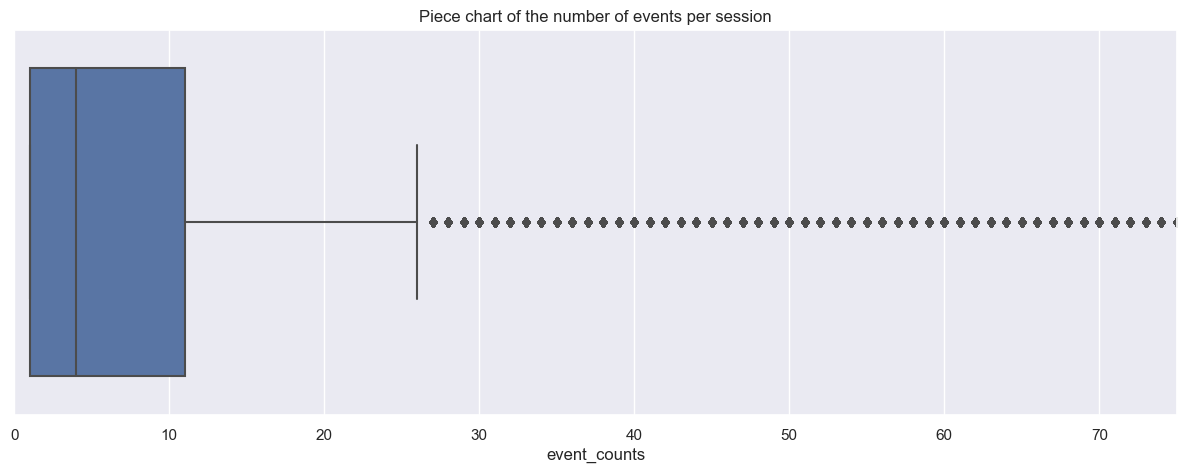

In [15]:
plt.figure(figsize=(15, 5))
plt.title('Piece chart of the number of events per session')
plt.xlim(0, 75)
sns.boxplot(x=event_counts);

### `event_action` - event type    

There are no empty values in the column. Unique values - 230.

Only 8 of them are targets in the task. And their number is 104,908 (0.66% of all events).

The most popular events are: `view_card`, `view_new_card`, `sub_landing`.

The most popular target events are: `sub_car_claim_click`, `sub_open_dialog_click`.

In [16]:
missings = count_missings(hits['event_action'])
print('Number of empty values in `event_action`:', missings)

Number of empty values in `event_action`: 0


In [17]:
print('Number of unique values in `event_action`:', hits["event_action"].nunique())

Number of unique values in `event_action`: 230


In [18]:
hits['event_action'].value_counts().head(25)

view_card                             3558985
view_new_card                         3551009
sub_landing                           1798117
go_to_car_card                         973666
sub_view_cars_click                    791515
search_form_region                     512069
search_form_search_btn                 433748
sap_search_form_cost_to                356596
showed_number_ads                      326274
pagination_click                       248944
search_form_mark_select                222652
quiz_show                              214037
search_form_model_select               211890
sap_search_form_cost_from              188129
photos_all                             181493
search_form_search_car_type_select     174877
photos                                 158543
sub_car_page                           130310
view_more_click                        109971
search_kpp                              79465
sub_header_link_click                   79192
proactive invitation shown        

In [19]:
print(f'Number of target events in hits:\n')
target_counts = hits['event_action'].value_counts()[target_events]

all = target_counts.sum()
print(f'Total ({as_percent(all/len(hits))}) {all:>23}')
target_counts.sort_values(ascending=False)

Number of target events in hits:

Total (0.66%)                  104289


sub_car_claim_click             37928
sub_open_dialog_click           25870
sub_submit_success              18439
sub_car_claim_submit_click      12359
sub_call_number_click            3653
sub_callback_submit_click        3074
sub_car_request_submit_click     2966
Name: event_action, dtype: int64

### Target Variable Extraction
We consider the target variable to be positive if at least one of the target events took place during the `sessions`. For those sessions in sessions for which no event was found in `hits`, fill the target variable with the `False` value.

The target variable is unevenly distributed - only 2.7% of sessions ended with the target action.

In [20]:
hits['target'] = hits['event_action'].isin(target_events)
target = hits.groupby('session_id')['target'].any()
sessions = sessions.join(target, on='session_id')

In [21]:
print('Target variable allocation:')
sessions['target'].value_counts(dropna=False, normalize=True).apply(as_percent)

Target variable allocation:


False    90.43%
NaN       6.87%
True      2.70%
Name: target, dtype: object

In [22]:
sessions['target'] = sessions['target'].fillna(False).astype(int)

## `sessions` anlysis

### General information

The table has 1,860,042 rows and 18 columns. There are no duplicates.

One column has a numeric type (`visit_number`), one column can be split into two numeric (`device_screen_resolution`), two columns represent date (`visit_date`) and time (`visit_time`), and the remaining columns are categorical.

In [23]:
sessions.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0


In [24]:
sessions.drop(columns='target').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 string
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
dtypes: int64(1), object(16), string(1)
memory usage: 255.4+ MB


In [25]:
print('Number of duplicates in sessions:', sessions.duplicated().sum())

Number of duplicates in sessions: 0


### `session_id` - session ID

There are no empty values in the column. All values in a column are unique.

This column will be used as an index in the final dataset.

In [26]:
missings = count_missings(sessions['session_id'])
print('Number of empty values in `session_id`:', missings)

Number of empty values in `session_id`: 0


In [27]:
all_unique = sessions['session_id'].nunique() == len(sessions)
print('All values of the `session_id` column are unique:', all_unique)

All values of the `session_id` column are unique: True


### `client_id` - visitor ID

There are no empty values in the column. And there are too many unique values.

It is unlikely that you will be able to extract useful information from this column. It simply won't be used.

In [28]:
missing = count_missings(sessions["client_id"])
print('Number of empty values in `client_id`:', missings)

Number of empty values in `client_id`: 0


In [29]:
print('Number of unique values in `client_id`:', sessions["client_id"].nunique())

Number of unique values in `client_id`: 1391719


### `visit_date` - visit date

There are no empty values in the column.

The range of dates shown is from May 19, 2021 to December 31, 2021.
It can be assumed that the full data for 2021 is given, since the SberAutosubscription service began work just in May 2021.

In general, there is a slight upward trend on the graph of the number of visits.
And on the graph, the peak of visits in May 2021 is very noticeable, most likely this is due to the advertising campaign, news about the new service, hype.
More sessions happen and more targeted actions happen at the start of the week.

The `visit_date` column itself will not participate in the final dataset, but it can be used to get the signs `visit_date_weekday` - the day of the week, `visit_date_weekend` - whether it is a day off, `visit_date_day` - the day of the month, `visit_date_holiday` - whether the day is a holiday in Russia.

In [30]:
sessions['visit_date'] = pd.to_datetime(sessions['visit_date'])

In [31]:
missings = count_missings(sessions['visit_date'])
print('Number of empty values in `visit_date`:', missings)

Number of empty values in `visit_date`: 0


In [32]:
n_unique = sessions['visit_date'].nunique()
print('Number of unique values in `visit_date`:', n_unique)

Number of unique values in `visit_date`: 226


In [33]:
sessions['visit_date'].describe(datetime_is_numeric=True)

count                          1860042
mean     2021-09-26 11:45:55.389394176
min                2021-05-19 00:00:00
25%                2021-08-02 00:00:00
50%                2021-10-06 00:00:00
75%                2021-11-23 00:00:00
max                2021-12-31 00:00:00
Name: visit_date, dtype: object

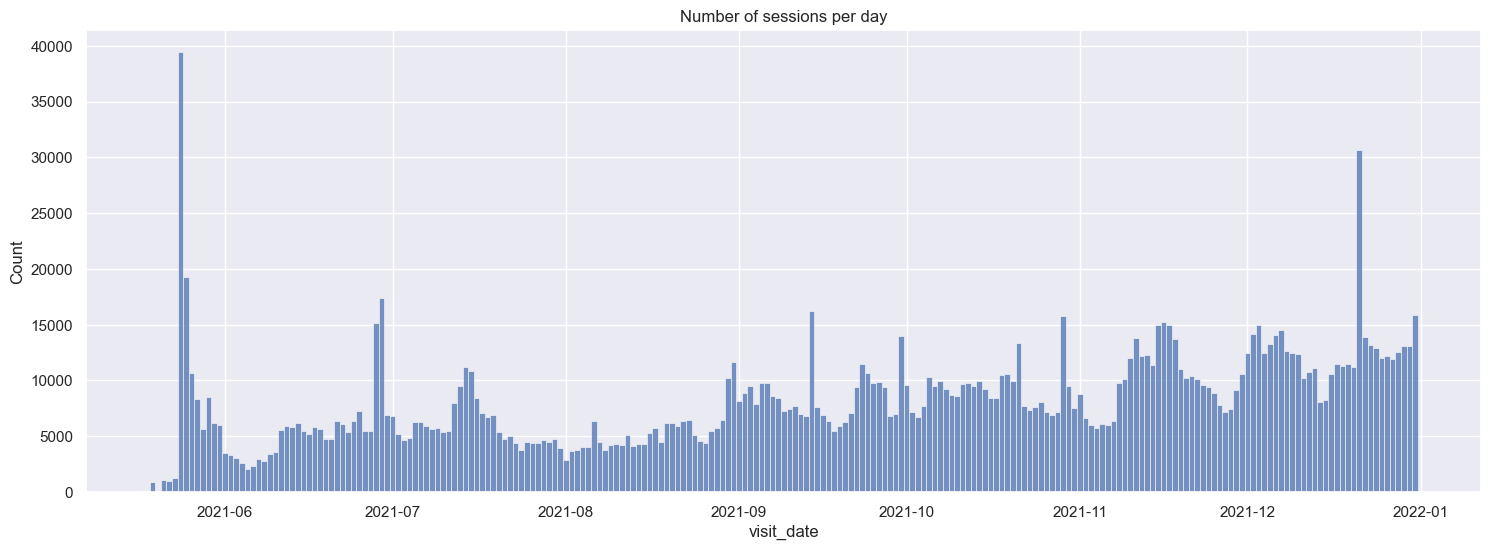

In [34]:
sns.histplot(sessions, x='visit_date', discrete=True)
plt.title('Number of sessions per day');

New feature - day of the week `visit_date_weekday`.

In [35]:
sessions['visit_date_weekday'] = sessions['visit_date'].dt.day_of_week

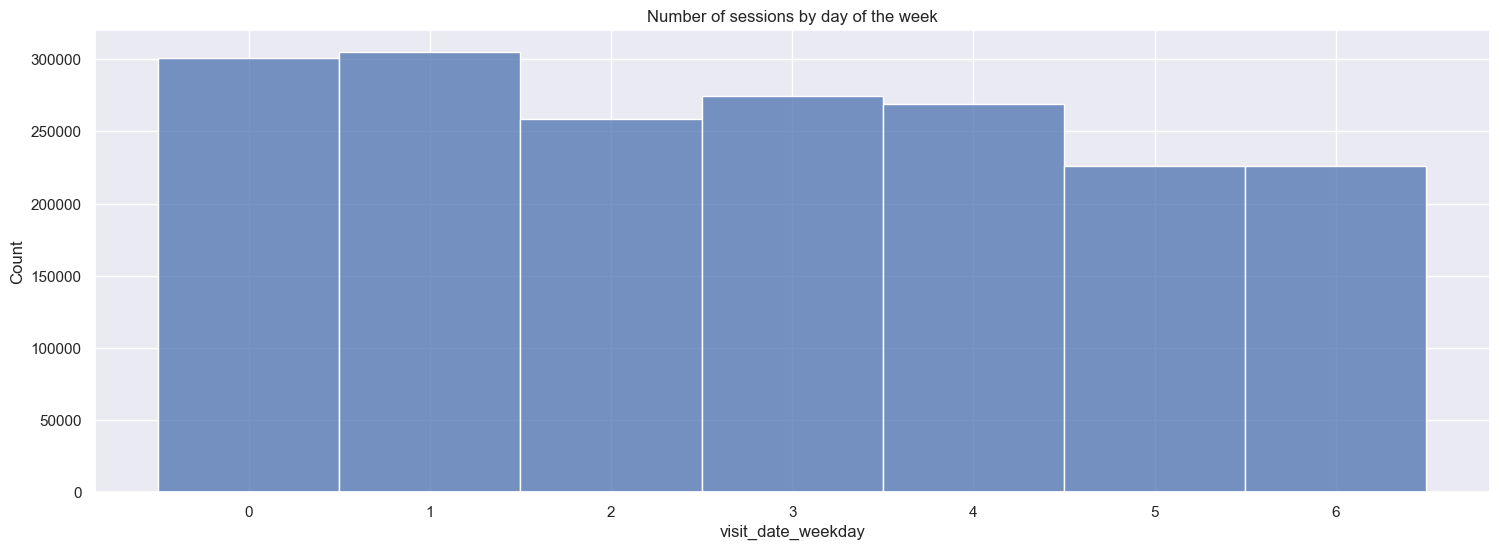

In [36]:
sns.histplot(data=sessions, x='visit_date_weekday', discrete=True)
plt.title('Number of sessions by day of the week');

In [37]:
print('Percentage of targeted actions by day of the week:')
target_percentage(sessions, 'visit_date_weekday', index_name='Day of the week')

Percentage of targeted actions by day of the week:


,Number of objects,Percentage of the total,Percentage of target actions
Day of the week,,,
0,300906,16.18%,3.15%
1,305130,16.40%,2.84%
2,258616,13.90%,2.81%
3,274462,14.76%,2.63%
5,226397,12.17%,2.46%
6,225712,12.13%,2.45%
4,268819,14.45%,2.44%


New feature, which tells about the day off `visit_date_weekend`.

In [38]:
sessions['visit_date_weekend'] = sessions['visit_date_weekday'] > 4

In [39]:
print('Distribution of days off:')
target_percentage(sessions, 'visit_date_weekend', index_name='Day off')

Distribution of days off:


,Number of objects,Percentage of the total,Percentage of target actions
Day off,,,
False,1407933,75.69%,2.78%
True,452109,24.31%,2.46%


New feature - the day of the month `visit_date_day`.

In [40]:
sessions['visit_date_day'] = sessions['visit_date'].dt.day

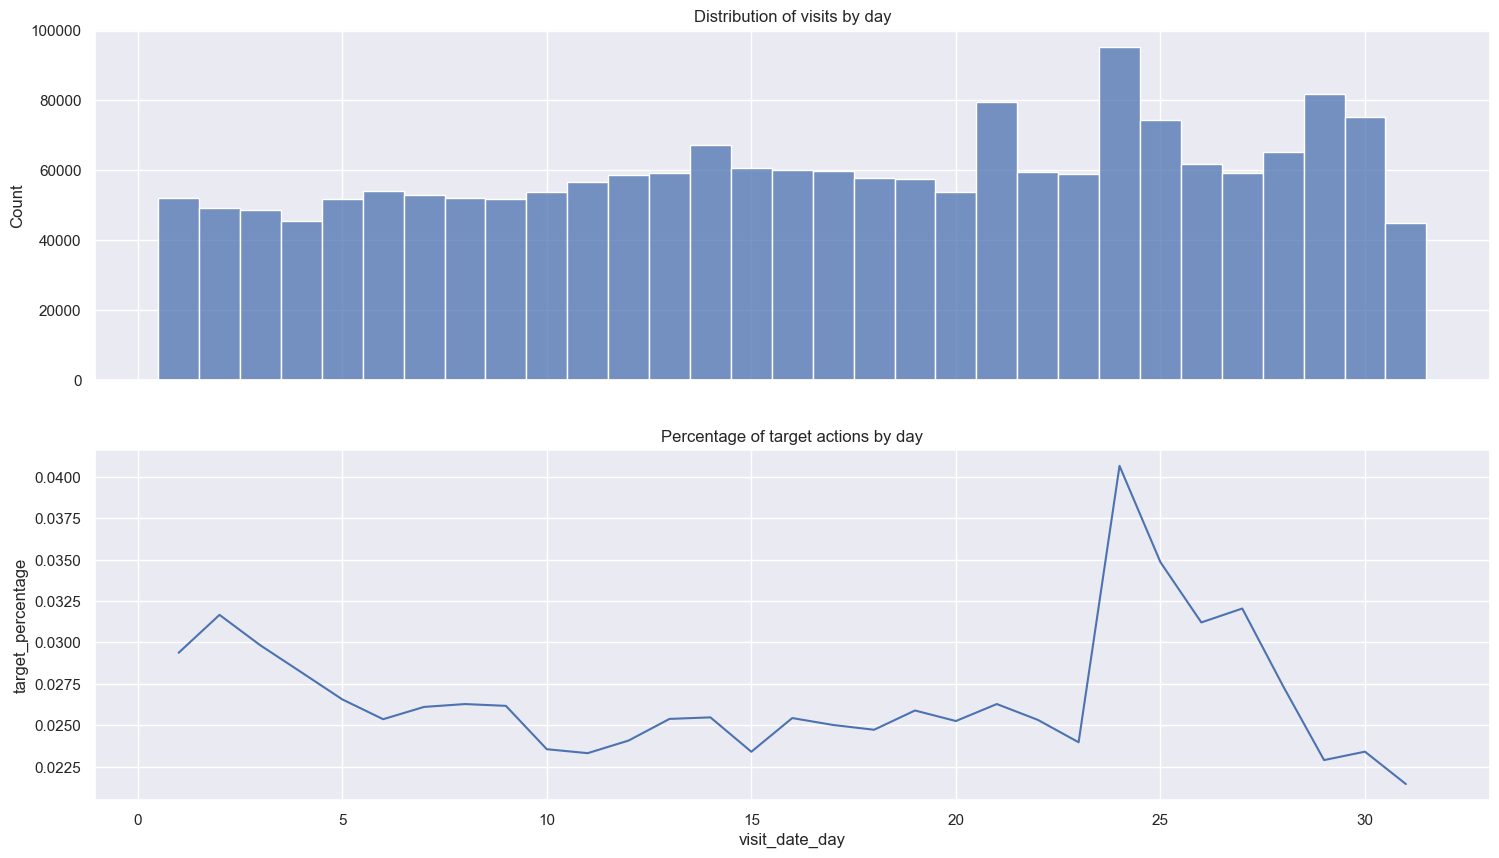

In [41]:
_, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(18, 10))

ax1.set_title('Distribution of visits by day')
sns.histplot(data=sessions, x='visit_date_day', discrete=True, ax=ax1)

target_by_day = target_percentage(sessions, 'visit_date_day', percent=False, only_target=True)
ax2.set_title('Percentage of target actions by day')
sns.lineplot(data=target_by_day, ax=ax2);

New feature that indicates the presence of a holiday on this day `visit_date_holiday`.

In [42]:
sessions['visit_date_holiday'] = sessions['visit_date'].isin(russian_holidays)

In [43]:
print('Holiday distribution:')
target_percentage(sessions, 'visit_date_holiday', index_name='Holiday')

Holiday distribution:


,Number of objects,Percentage of the total,Percentage of target actions
Holiday,,,
False,1820148,97.86%,2.71%
True,39894,2.14%,2.54%


### `visit_time` - visit time

There are no empty values in the column.

Time values are from 00:00:00 to 23:59:59, which means they cover the entire day.
The peak of visits to the site is observed at 14:00, that is, in the middle of the day.
The decline in the number of visits is in the middle of the night, at 04:00.

A larger percentage of sessions are closed by a target action in the middle of the day (11:00-16:00), and a smaller percentage - at night (2:00-6:00).
Most sessions take place at the zero minute of every hour, and with a large percentage of targeted actions. This is more like algorithmic actions than real user visits to the site.

By itself, the `visit_time` attribute is inconvenient to use, but useful attributes can be obtained from it, for example, `visit_hour` - the hour of the user's visit, `visit_minute` - the minute of the visit, `visit_time_night` - whether it was night during the user's visit.

In [44]:
sessions['visit_time'] = pd.to_datetime(sessions['visit_time'])

In [45]:
missings = count_missings(sessions['visit_time'])
print('Number of empty values at `visit_time`:', missings)

Number of empty values at `visit_time`: 0


In [46]:
sessions['visit_time'].describe(datetime_is_numeric=True)

count                          1860042
mean     2023-05-02 13:49:53.502090752
min                2023-05-02 00:00:00
25%                2023-05-02 10:00:00
50%                2023-05-02 14:09:06
75%                2023-05-02 19:00:00
max                2023-05-02 23:59:59
Name: visit_time, dtype: object

New feature - the number of hours `visit_time_hour`.

In [47]:
sessions['visit_time_hour'] = sessions['visit_time'].dt.hour

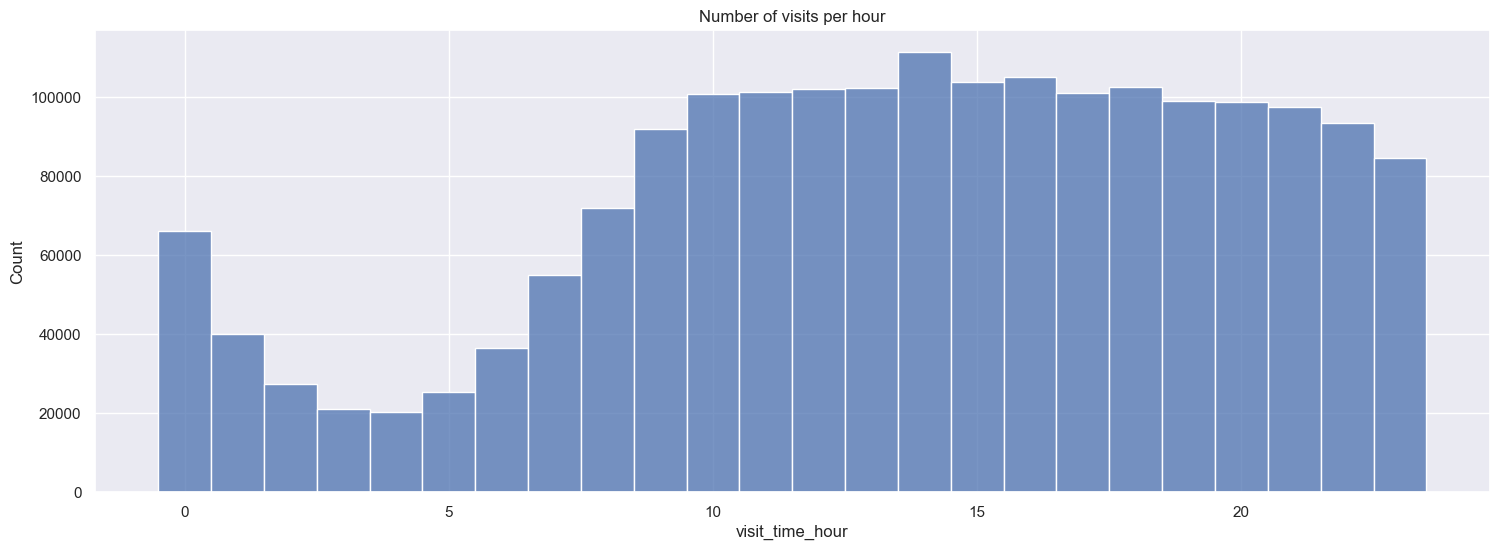

In [48]:
sns.histplot(data=sessions, x='visit_time_hour', discrete=True)
plt.title('Number of visits per hour');

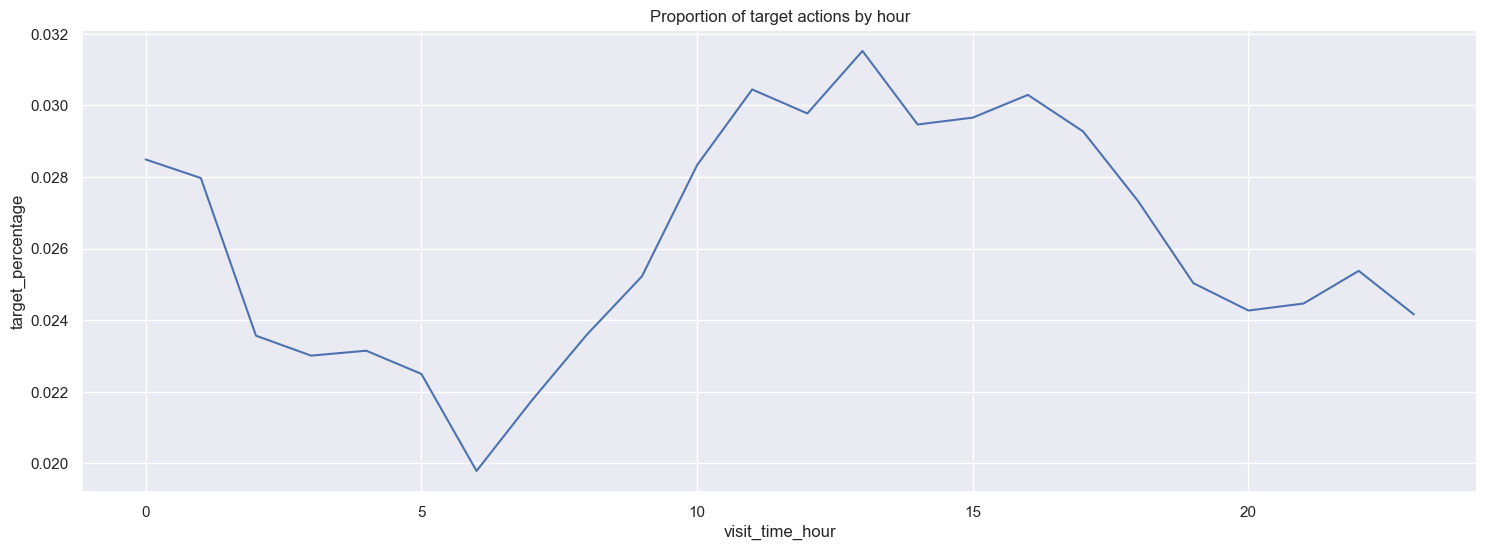

In [49]:
target_by_hour = target_percentage(sessions, 'visit_time_hour', percent=False, only_target=True)
sns.lineplot(data=target_by_hour)
plt.title('Proportion of target actions by hour');

New feature - the number of minutes `visit_time_minute`.

In [50]:
sessions['visit_time_minute'] = sessions['visit_time'].dt.minute

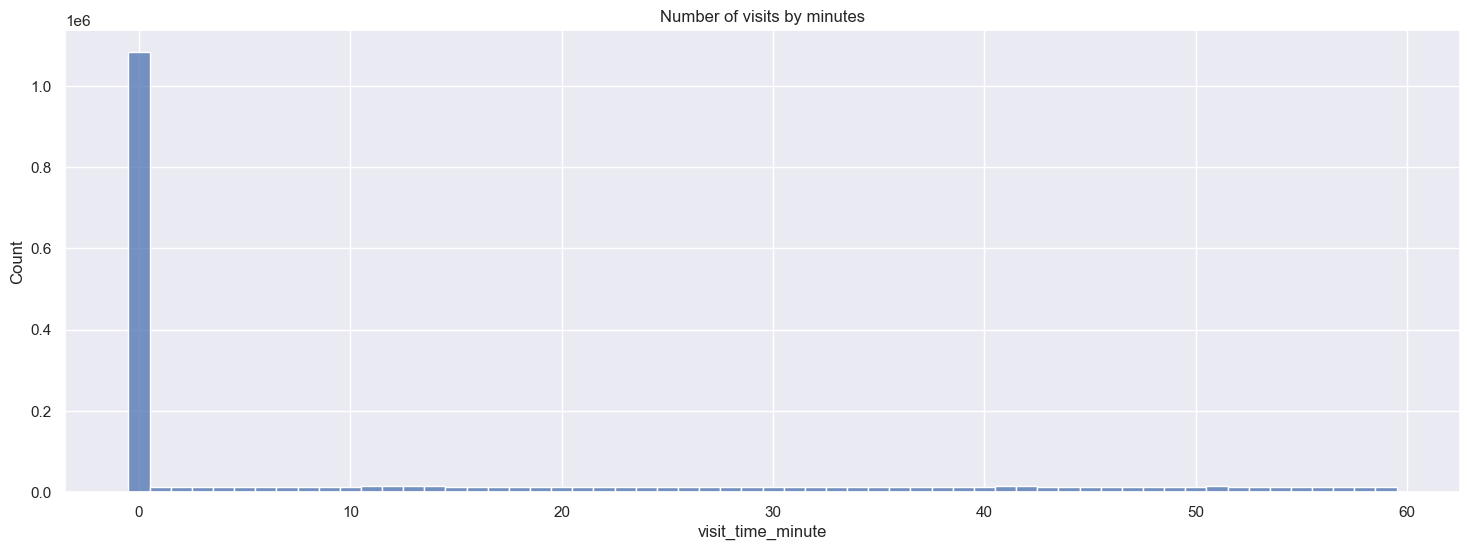

In [51]:
sns.histplot(data=sessions, x='visit_time_minute', discrete=True)
plt.title('Number of visits by minutes');

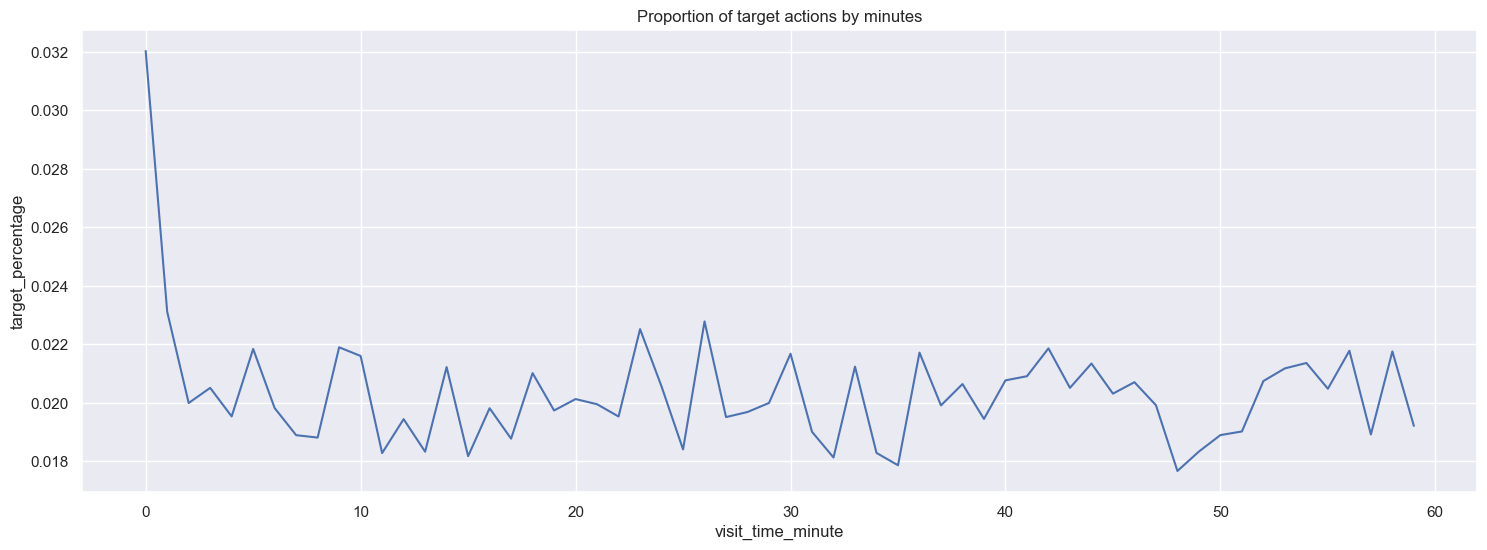

In [52]:
target_by_minute = target_percentage(sessions, 'visit_time_minute', percent=False, only_target=True)
sns.lineplot(data=target_by_minute)
plt.title('Proportion of target actions by minutes');

In [53]:
sessions['visit_time_minute_is_zero'] = sessions['visit_time_minute'] == 0
target_percentage(sessions, 'visit_time_minute_is_zero', index_name='0 минут')

,Number of objects,Percentage of the total,Percentage of target actions
0 минут,,,
True,1083333,58.24%,3.20%
False,776709,41.76%,2.01%


Create a new feature that indicates the onset of night - `visit_time_night`.

In [54]:
sessions['visit_time_night'] = sessions['visit_time_hour'] < 9

In [55]:
print('Distribution of target actions during the night and during the day:')
target_percentage(sessions, 'visit_time_night', index_name='Night time')

Distribution of target actions during the night and during the day:


,Number of objects,Percentage of the total,Percentage of target actions
Night time,,,
False,1496535,80.46%,2.77%
True,363507,19.54%,2.42%


### `visit_number` - sequence number of the visitor's visit

There are no empty values in the column.

The number ranges from 1 to 564 (obviously there are outliers) site visits. Although most users are limited to one or two visits.

It seems that the more often a user visits a site, the more likely they are to take a targeted action.
Probably, the first time users come to the site to get acquainted with the offer, and if they are interested in it, they will come back again.

In [56]:
missings = count_missings(sessions['visit_number'])
print('Number of empty values in `visit_number`:', missings)

Number of empty values in `visit_number`: 0


In [57]:
sessions['visit_number'].describe().apply(lambda x: f'{x:0.1f}')

count    1860042.0
mean           2.7
std           11.8
min            1.0
25%            1.0
50%            1.0
75%            2.0
max          564.0
Name: visit_number, dtype: object

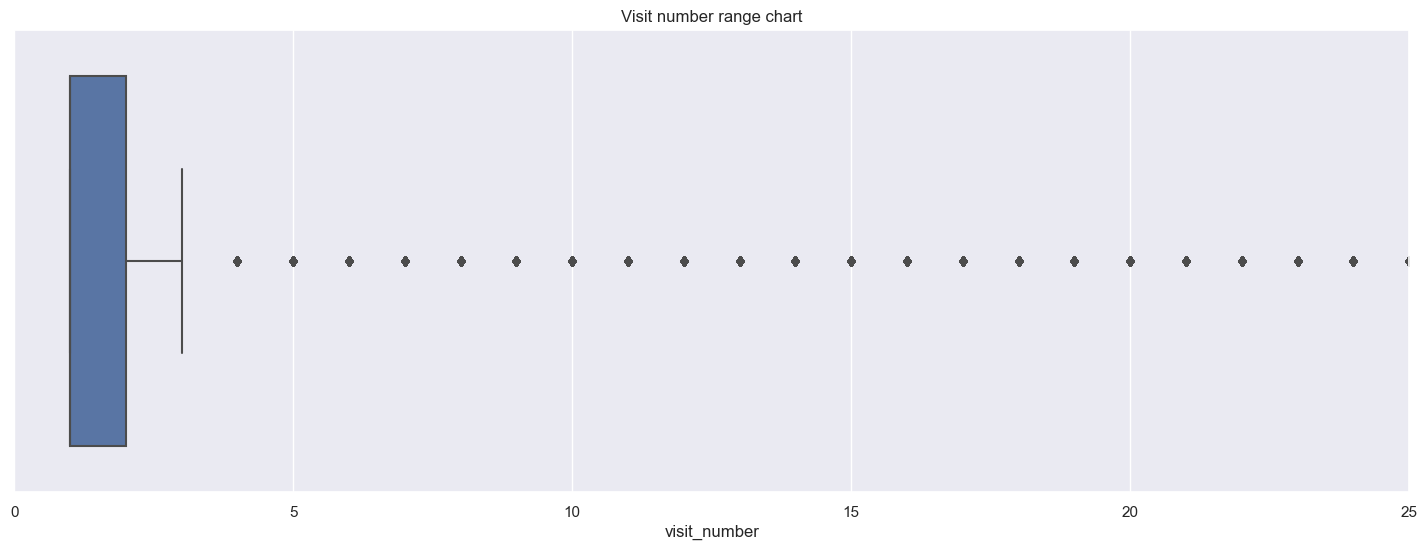

In [58]:
sns.boxplot(data=sessions, x='visit_number')
plt.xlim(0, 25)
plt.title('Visit number range chart');

In [59]:
# bring all outliers to value 4
sessions['visit_number_no_outliers'] = sessions['visit_number'].apply(lambda x: x if x < 4 else 4)

In [60]:
print('Percentage of successful sessions depending on visit number: ')
target_percentage(sessions, 'visit_number_no_outliers', index_name='Visit number')

Percentage of successful sessions depending on visit number: 


,Number of objects,Percentage of the total,Percentage of target actions
Visit number,,,
4,166969,8.98%,4.37%
3,81068,4.36%,3.76%
2,235656,12.67%,3.23%
1,1376349,74.00%,2.35%


### `utm_source` - attraction channel

There are not many gaps in the column - 97.

There are many unique values (293) and they are unlikely to carry much useful information, you can only take the most frequent values ​​in the final dataset.

15% of traffic from social networks. But the percentage of targeted actions for it is two times lower than for the rest of the traffic.
For popular acquisition channels, the percentage of targeted actions varies from 1.21% to 5.43%.

In [61]:
missings = count_missings(sessions['utm_source'])
print('Number of empty values in `utm_source`:', missings)

Number of empty values in `utm_source`: 97


In [62]:
n_unique = sessions['utm_source'].nunique()
print('Number of unique values in `utm_source`:', n_unique)

Number of unique values in `utm_source`: 293


In [63]:
sessions['utm_source'].value_counts(dropna=False).head(15)

ZpYIoDJMcFzVoPFsHGJL    578290
fDLlAcSmythWSCVMvqvL    300575
kjsLglQLzykiRbcDiGcD    266354
MvfHsxITijuriZxsqZqt    186199
BHcvLfOaCWvWTykYqHVe    116320
bByPQxmDaMXgpHeypKSM    102287
QxAxdyPLuQMEcrdZWdWb     51415
aXQzDWsJuGXeBXexNHjc     31152
jaSOmLICuBzCFqHfBdRg     29241
RmEBuqrriAfAVsLQQmhk     28055
vFcAhRxLfOWKhvxjELkx     24413
PlbkrSYoHuZBWfYjYnfw     20792
hTjLvqNxGggkGnxSCaTm     14598
gDBGzjFKYabGgSPZvrDH     13565
fgymSoTvjKPEgaIJqsiH      9625
Name: utm_source, dtype: int64

In [64]:
print('Percentage of target actions for frequent acquisition channel values:')
sessions['utm_source_frequent'] = replace_rare(sessions['utm_source'])
target_percentage(sessions, 'utm_source_frequent', index_name='Acquisition channel')

Percentage of target actions for frequent acquisition channel values:


,Number of objects,Percentage of the total,Percentage of target actions
Acquisition channel,,,
bByPQxmDaMXgpHeypKSM,102287,5.50%,5.43%
fDLlAcSmythWSCVMvqvL,300575,16.16%,3.50%
BHcvLfOaCWvWTykYqHVe,116320,6.25%,3.34%
ZpYIoDJMcFzVoPFsHGJL,578290,31.09%,2.77%
kjsLglQLzykiRbcDiGcD,266354,14.32%,2.36%
rare_other,310017,16.67%,1.87%
MvfHsxITijuriZxsqZqt,186199,10.01%,1.21%


Create a new feature indicating that the user has moved to the site from social networks - `utm_source_is_social`.

In [65]:
sessions['utm_source_is_social'] = sessions['utm_source'].isin(social_media_sources)

In [66]:
print('Percentage of targeted actions for users from social networks and others:')
target_percentage(sessions, 'utm_source_is_social', index_name='From social networks')

Percentage of targeted actions for users from social networks and others:


,Number of objects,Percentage of the total,Percentage of target actions
From social networks,,,
False,1585815,85.26%,2.92%
True,274227,14.74%,1.47%


### `utm_medium` - attraction type

Empty values in the `utm_medium` column 301 055 - values (none) and (not set). There are few unique values - 56.

Too many values appear in the dataset too few times.

Organic traffic is 28%. And for him, the percentage of targeted actions is much higher than for other types of attraction.
The most popular traffic types are: banner, cpc, cpm, refferal, organic.

For the most frequent values of `utm_medium`, the percentage of target actions varies from 1.04% to 5.38%.

In [67]:
missings = count_missings(sessions['utm_medium'])
print('Number of empty values in `utm_medium`:', missings)

Number of empty values in `utm_medium`: 301055


In [68]:
n_unique = sessions['utm_medium'].nunique()
print('Number of unique values in `utm_medium`:',n_unique)

Number of unique values in `utm_medium`: 56


In [69]:
sessions['utm_medium'].value_counts(dropna=False).head(15)

banner             552272
cpc                434794
(none)             300575
cpm                242083
referral           152050
organic             63034
email               29240
push                28035
stories             10582
cpv                  8022
blogger_channel      8015
smartbanner          6794
blogger_stories      4312
cpa                  4279
tg                   4011
Name: utm_medium, dtype: int64

In [70]:
print('Percentage of target actions for frequent values of attraction type:')
sessions['utm_medium_frequent'] = replace_rare(sessions['utm_medium'])
target_percentage(sessions, 'utm_medium_frequent', index_name='Attraction Type')

Percentage of target actions for frequent values of attraction type:


,Number of objects,Percentage of the total,Percentage of target actions
Attraction Type,,,
referral,152050,8.17%,5.38%
(none),300575,16.16%,3.50%
banner,552272,29.69%,2.74%
rare_other,178268,9.58%,2.49%
cpc,434794,23.38%,2.19%
cpm,242083,13.01%,1.04%


Create a new feature responsible for organic traffic - `utm_medium_is_organic`.

In [71]:
sessions['utm_medium_is_organic'] = sessions['utm_medium'].isin(organic_mediums)

In [72]:
print('Organic traffic distribution:')
target_percentage(sessions, 'utm_medium_is_organic', index_name='Organic Traffic')

Organic traffic distribution:


,Number of objects,Percentage of the total,Percentage of target actions
Organic Traffic,,,
True,515659,27.72%,4.04%
False,1344383,72.28%,2.19%


### `utm_campaign` - advertising campaign

12% of the values in the column are missing.
There are 412 unique values in column, and most of the unique values are very rare in the dataset.

For the most frequent values, the percentage of target actions varies from 0.99% to 4.10%.

In [73]:
missings = count_missings(sessions['utm_campaign']) / len(sessions)
print(f'Number of missing values in `utm_campaign`: {missings:0.2%}')

Number of missing values in `utm_campaign`: 11.81%


In [74]:
n_unique = sessions['utm_campaign'].nunique()
print('Number of unique values in `utm_campaign` =', n_unique)

Number of unique values in `utm_campaign` = 412


In [75]:
sessions['utm_campaign'].value_counts(dropna=False).head(15)

LTuZkdKfxRGVceoWkVyg    463481
LEoPHuyFvzoNfnzGgfcd    324044
FTjNLDyTrXaWYgZymFkV    247360
NaN                     219603
gecBYcKZCPMcVYdSSzKP    134042
TmThBvoCcwkCZZUWACYq     26597
XHNUiSKKGTEpSAlaVMFQ     24524
okTXSMadDkjvntEHzIjp     24511
SgIUDYUKnyWHVowUOqid     22841
sbJRYgVfvcnqKJNDDYIr     20188
LwJZxKuWmvOhPsaCeRjG     17615
RoDitORHdzGfGhNCyEMy     15706
bxOTvPtyGSdUrbwoXCPO     15415
zxoiLxhuSIFrCeTLQVWZ     12370
bJJuEXRheRIxXEaYIXqM     12232
Name: utm_campaign, dtype: int64

In [76]:
print('Percentage of target actions for the most frequent values of the advertising campaign:')
sessions['utm_campaign_frequent'] = replace_rare(sessions['utm_campaign'], 0.05)
target_percentage(sessions, 'utm_campaign_frequent', index_name='Advertising Campaign')

Percentage of target actions for the most frequent values of the advertising campaign:


,Number of objects,Percentage of the total,Percentage of target actions
Advertising Campaign,,,
LTuZkdKfxRGVceoWkVyg,463481,24.92%,4.10%
gecBYcKZCPMcVYdSSzKP,134042,7.21%,3.39%
(nan),219603,11.81%,3.27%
LEoPHuyFvzoNfnzGgfcd,324044,17.42%,2.88%
rare_other,471512,25.35%,1.65%
FTjNLDyTrXaWYgZymFkV,247360,13.30%,0.99%


### `utm_adcontent`

18% of the values in the column are missing.
There are 286 unique values in the column, but most of them are too rare in the data.

For popular values, the percentage of targeted actions varies from 1.08% to 3.37%.

In [77]:
missings = count_missings(sessions['utm_adcontent']) / len(sessions)
print(f'Number of missing values in `utm_adcontent`: {missings:0.2%}')

Number of missing values in `utm_adcontent`: 18.04%


In [78]:
n_unique = sessions['utm_adcontent'].nunique()
print('Number of unique values in `utm_adcontent` =', n_unique)

Number of unique values in `utm_adcontent` = 286


In [79]:
sessions['utm_adcontent'].value_counts(dropna=False).head(15)

JNHcPlZPxEMWDnRiyoBf    1006599
NaN                      335615
vCIpmpaGBnIQhyYNkXqp     181048
xhoenQgDQsgfEPYNPwKO     113072
PkybGvWbaqORmxjNunqZ      60316
LLfCasrxQzJIyuldcuWy      24222
TuyPWsGQruPMpKvRxeBF      18189
UxrnyMlRBSOhOjytXnMG      13583
dUuXlWzvmhDSyclWRhNP      10280
yYdBRbPmBMUZHXwqGxNx       9700
WYLajZgbUhGimwBKDZUH       8610
SOkCdPxfUcZUzzOdgGES       7319
AdeErYgVTbRcAWtHrMHq       6391
nNqUcgFgcqQbTVSvgaHr       6192
aYAcKhelKzYpXrRYknSP       5090
Name: utm_adcontent, dtype: int64

In [80]:
print('Percentage of target actions for frequent values utm_adcontent:')
sessions['utm_adcontent_frequent'] = replace_rare(sessions['utm_adcontent'])
target_percentage(sessions, 'utm_adcontent_frequent')

Percentage of target actions for frequent values utm_adcontent:


,Number of objects,Percentage of the total,Percentage of target actions
utm_adcontent_frequent,,,
JNHcPlZPxEMWDnRiyoBf,1006599,54.12%,3.37%
(nan),335615,18.04%,2.61%
vCIpmpaGBnIQhyYNkXqp,181048,9.73%,2.16%
xhoenQgDQsgfEPYNPwKO,113072,6.08%,1.12%
rare_other,223708,12.03%,1.08%


### `utm_keyword` - keyword

There are a lot of missing values in the column - 58%. And the unique values in the column are 1219, which indicates the low value of this column. Most likely, only the most popular value puhZPIYqKXeFPaUviSjo will be taken from this column.

A larger percentage of target actions for objects with missing keyword values.

In [81]:
missing = count_missings(sessions['utm_keyword']) / len(sessions)
print(f'Number of missing values in `utm_keyword`: {missings:0.2%}')

Number of missing values in `utm_keyword`: 18.04%


In [82]:
n_unique = sessions['utm_keyword'].nunique()
print('Number of unique values in `utm_keyword` =', n_unique)

Number of unique values in `utm_keyword` = 1219


In [83]:
sessions['utm_keyword'].value_counts(dropna=False).head(15)

NaN                     1082061
puhZPIYqKXeFPaUviSjo     506819
aXQzDWsJuGXeBXexNHjc      24241
pHqgLcdBQPSLcrTpLkdr      13767
ITfrGJNwVsHBGJMAKoct      13353
hAmNSZmQkKQKAjZEGlgb      11297
UKNBOHebRIIsQRsjNKay      10946
IGUCNvHlhfHpROGclCit       7568
RkpOyeEPgcMBSDuHLQcj       6978
JajANoFxoqXfKRNBUhzx       6758
BmOOOIoWGHEfxEfoUezs       6602
ZNhSIPchlbnKwZWcsKzz       5661
pucKZkLDtpMDBTobJAJG       5391
RrhnkuoaqckNtJpAZDzH       5004
YQXPpoLsxnykCWKhGEmI       4874
Name: utm_keyword, dtype: int64

In [84]:
print('Percentage of target actions for frequent values utm_keyword:')
sessions['utm_keyword_frequent'] = replace_rare(sessions['utm_keyword'], 0.01)
target_percentage(sessions, 'utm_keyword_frequent')

Percentage of target actions for frequent values utm_keyword:


,Number of objects,Percentage of the total,Percentage of target actions
utm_keyword_frequent,,,
(nan),1082061,58.17%,3.20%
puhZPIYqKXeFPaUviSjo,506819,27.25%,2.21%
rare_other,246921,13.28%,1.81%
aXQzDWsJuGXeBXexNHjc,24241,1.30%,0.30%


### `device_category` - device type

There are no missing values in the column.
There are few unique values, which means that there will be no problems using the column.

Users performed more targeted actions (as a percentage) from a computer than from mobile devices.

In [85]:
missings = count_missings(sessions['device_category'])
print('Number of missing values in `device_category`:', missings)

Number of missing values in `device_category`: 0


In [86]:
n_unique = sessions['device_category'].nunique()
print('Number of unique values in `device_category` =', n_unique)

Number of unique values in `device_category` = 3


In [87]:
sessions['device_category'].value_counts(dropna=False)

mobile     1474871
desktop     366863
tablet       18308
Name: device_category, dtype: int64

In [88]:
print('Percentage of targeted actions by device category: ')
target_percentage(sessions, 'device_category', index_name='Device Type')

Percentage of targeted actions by device category: 


,Number of objects,Percentage of the total,Percentage of target actions
Device Type,,,
desktop,366863,19.72%,3.14%
mobile,1474871,79.29%,2.60%
tablet,18308,0.98%,2.31%


### `device_os` - device OS

Missing values in the column 58%. There are 13 unique values, but most are too rare.

A larger percentage of targeted actions were performed from devices with an unknown OS and Macintosh.

In [89]:
device_os = sessions['device_os']

In [90]:
missings = count_missings(sessions['device_os']) / len(sessions)
print(f'Number of missing values in `device_os`: {missings:0.2%}')

Number of missing values in `device_os`: 57.55%


In [91]:
n_unique = sessions['device_os'].nunique()
print('Number of unique values in `device_os` =', n_unique)

Number of unique values in `device_os` = 13


In [92]:
device_os.value_counts(dropna=False)

NaN              1070138
Android           464054
iOS               207104
Windows            88307
Macintosh          24824
Linux               5120
(not set)            364
Chrome OS             83
BlackBerry            27
Tizen                  7
Samsung                4
Windows Phone          4
Firefox OS             3
Nokia                  3
Name: device_os, dtype: int64

In [93]:
print('Percentage of targeted actions for popular operating systems: ')
sessions['device_os_frequent'] = replace_rare(sessions['device_os'], 0.01)
target_percentage(sessions, 'device_os_frequent', index_name='OS')

Percentage of targeted actions for popular operating systems: 


,Number of objects,Percentage of the total,Percentage of target actions
OS,,,
(nan),1070138,57.53%,3.22%
Macintosh,24824,1.33%,3.11%
Android,464054,24.95%,2.04%
iOS,207104,11.13%,1.89%
Windows,88307,4.75%,1.85%
rare_other,5615,0.30%,1.60%


### `device_brand` - device brand

The number of missing values in the column is about 20%. Unique values 205.

The percentage of targeted actions for popular brands varies in a small range from 2.29% to 3.14%. Moreover, a larger percentage of devices of an unknown brand.

In [94]:
missings = count_missings(sessions['device_brand']) / len(sessions)
print(f'Количество пропущенных значений в `device_brand`: {missings:0.2%}')

Количество пропущенных значений в `device_brand`: 20.68%


In [95]:
n_unique = sessions['device_brand'].nunique()
print('Number of unique values in `device_brand` =', n_unique)

Number of unique values in `device_brand` = 205


In [96]:
sessions['device_brand'].value_counts(dropna=False).head(15)

Apple        551088
NaN          367178
Samsung      332194
Xiaomi       288367
Huawei       185853
Realme        19058
(not set)     17545
OPPO          13504
Vivo          11740
OnePlus        9965
Asus           7929
Nokia          7285
Sony           6459
ZTE            6365
Google         5150
Name: device_brand, dtype: int64

In [97]:
print('Percentage of targeted actions for frequent device brand values:')
sessions['device_brand_frequent'] = replace_rare(sessions['device_brand'])
target_percentage(sessions, 'device_brand_frequent', index_name='Device brand')

Percentage of targeted actions for frequent device brand values:


,Number of objects,Percentage of the total,Percentage of target actions
Device brand,,,
(nan),367178,19.74%,3.14%
Samsung,332194,17.86%,3.03%
Apple,551088,29.63%,2.63%
Huawei,185853,9.99%,2.43%
rare_other,135362,7.28%,2.34%
Xiaomi,288367,15.50%,2.29%


### `device_model` - device model

Missing values in the column - 99%, which means it will not be used.

In [98]:
missings = count_missings(sessions['device_model']) / len(sessions)
print(f'Number of missing values in `device_model`: {missings:0.2%}')

Number of missing values in `device_model`: 99.12%


In [99]:
n_unique = sessions['device_model'].nunique()
print('Number of unique values in `device_model` =', n_unique)

Number of unique values in `device_model` = 104


In [100]:
sessions['device_model'].value_counts(dropna=False).head(15)

NaN                     1843704
AuMdmADEIoPXiWpTsBEj       9778
tWBQlsvNfHxRUjaPAfhd        653
cwMJxNXiWUgMUxGiCTPs        651
pTgAEPipQxDXCjPrJbHo        461
FJApgTrMAGHoxCxQVKws        372
tfPZFRbtlzEssBEesRwM        335
pcvPxfVFaAmhwFmvIeYd        325
aCLaTVQlHcXbUnQYQvIg        236
mzJXHtJPIOSHoHtgezIA        235
JAIKWwxRffFOXQcfGTVi        198
zFCiMWkbbAhTflrlLWnz        176
jXFxTkHxuiBKWOvUtsIa        170
mSVMBvlHFgftJaQAZEdp        152
AshpvdJdReafUzEMmWGr        141
Name: device_model, dtype: int64

In [101]:
print('Distribution of missing and remaining values of device_model:')
sessions['device_model_frequent'] = replace_rare(sessions['device_model'], 0.01)
target_percentage(sessions, 'device_model_frequent')

Distribution of missing and remaining values of device_model:


,Number of objects,Percentage of the total,Percentage of target actions
device_model_frequent,,,
(nan),1843704,99.12%,2.71%
rare_other,16338,0.88%,2.09%


### `device_screen_resolution` - screen resolution

There are 19 missing values in the column (values '0x0', '(not set)'). It would be convenient to replace them with the most frequent value in the column. There are a lot of unique values - 5039.

You won't be able to use the feature directly, but you can get new features from it, such as aspect ratio, area, screen width and height.

But in such derived features there are many outliers that need to be processed.

The target variable does not correlate with any derived feature. Based on the swipe charts, users with higher screen resolutions are more likely to take the targeted action.

In [102]:
missings = count_missings(sessions['device_screen_resolution'])
print('Missing values in `device_screen_resolution`:', missings)

Missing values in `device_screen_resolution`: 19


In [103]:
missed_mask = sessions['device_screen_resolution'].isin(missing_values)
sessions[missed_mask]['device_screen_resolution'].value_counts(dropna=False)

0x0          11
(not set)     8
Name: device_screen_resolution, dtype: int64

In [104]:
n_unique = sessions['device_screen_resolution'].nunique()
print('Unique values in `device_screen_resolution` =', n_unique)

Unique values in `device_screen_resolution` = 5039


In [105]:
sessions['device_screen_resolution'].value_counts(dropna=False).head()

414x896      169090
1920x1080    125768
375x812      117944
393x851      115454
375x667       93341
Name: device_screen_resolution, dtype: int64

Split the column into width and height - `device_screen_width` and `device_screen_height`.

In [106]:
split = sessions['device_screen_resolution']\
    .replace(missing_values, '414x896')\
    .str.split('x', expand=True).astype(int)
sessions[['device_screen_width', 'device_screen_height']] = split

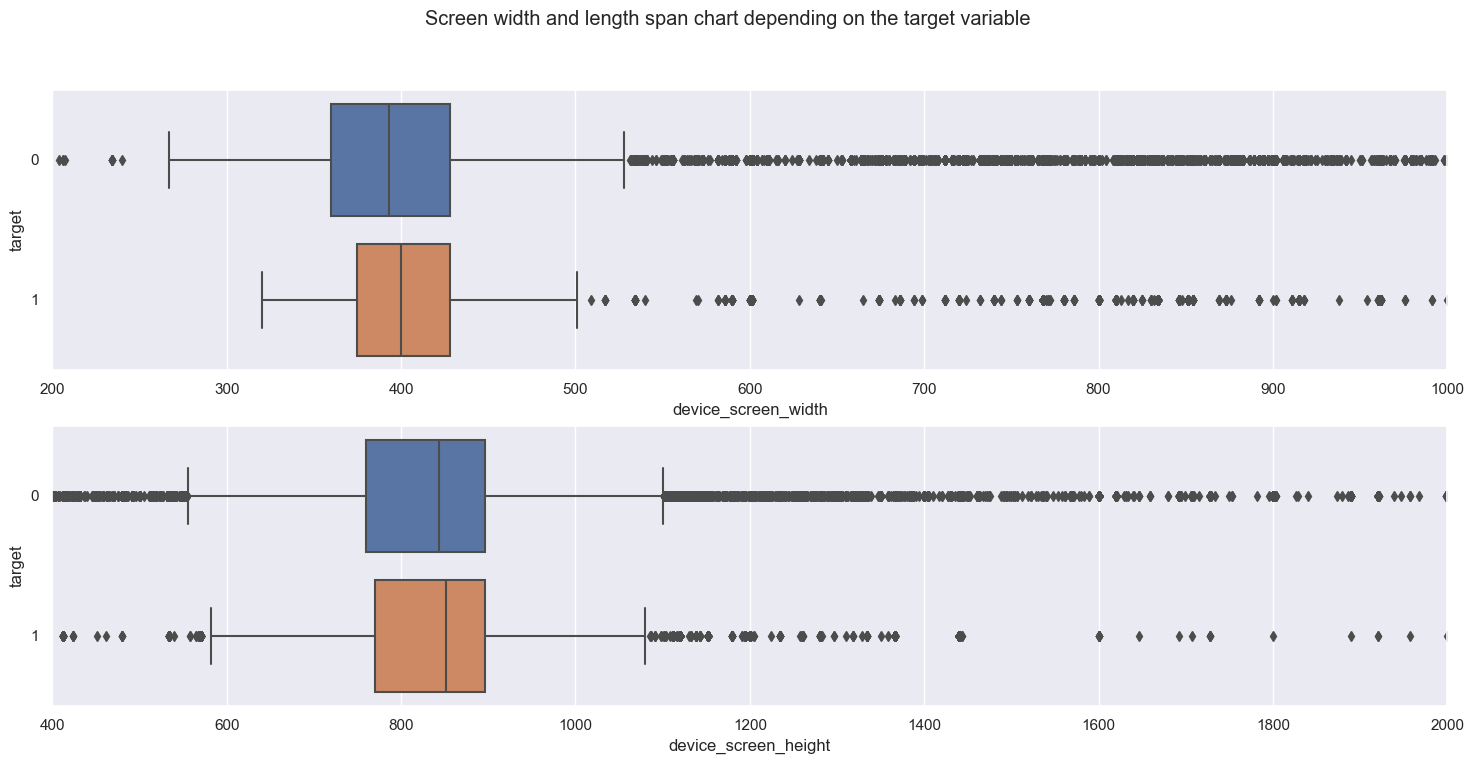

In [107]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18, 8))

sns.boxplot(data=sessions, x='device_screen_width', y='target', ax=ax1, orient='h')
sns.boxplot(data=sessions, x='device_screen_height', y='target', ax=ax2, orient='h')

# limit display of outliers
ax1.set_xlim(200, 1000)
ax2.set_xlim(400, 2000)

fig.suptitle(f'Screen width and length span chart depending on the target variable')
plt.show()

Create additional features - screen area `device_screen_area` and aspect ratio `device_screen_ratio`.

In [108]:
sessions['device_screen_area'] = sessions['device_screen_width'] * sessions['device_screen_height']
sessions['device_screen_ratio'] = sessions['device_screen_width'] / sessions['device_screen_height']

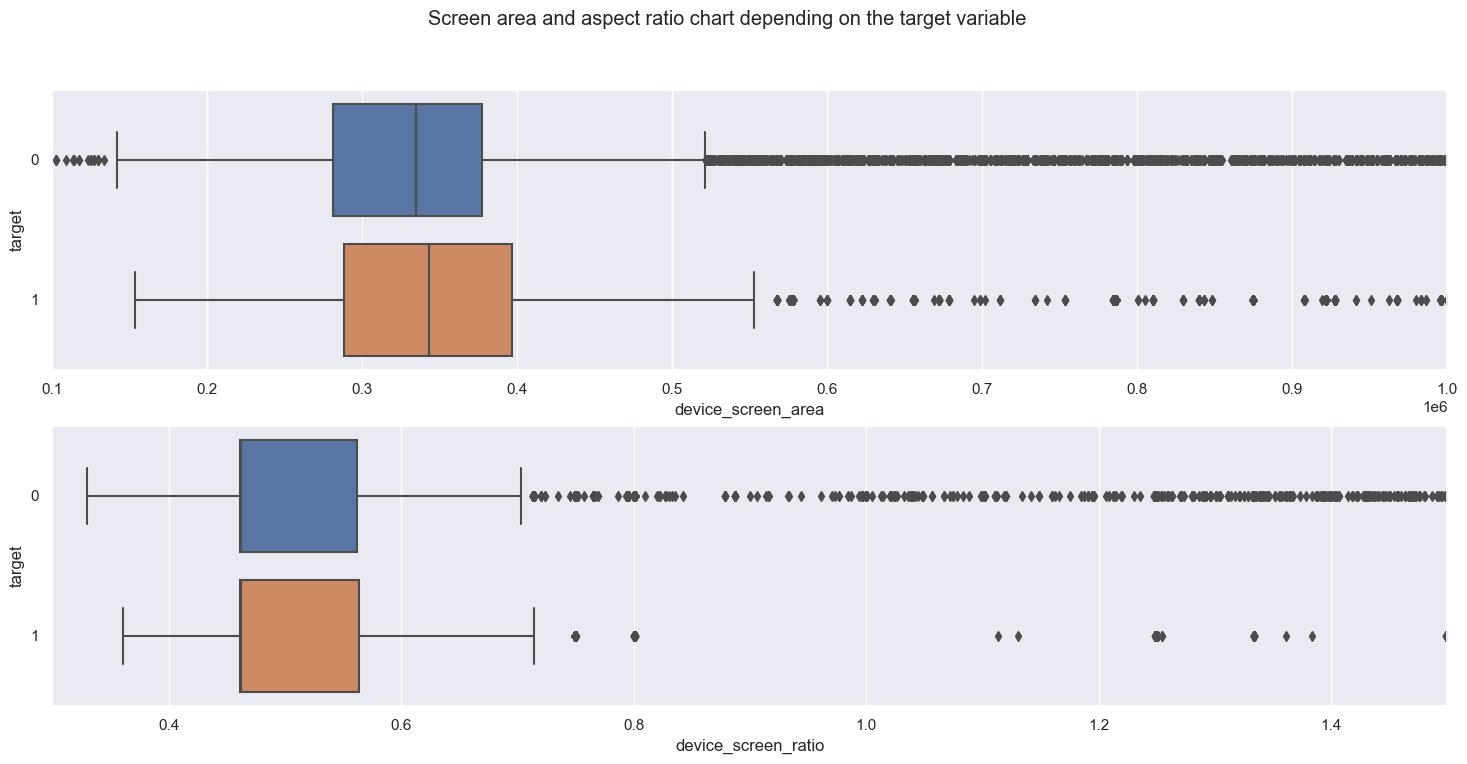

In [109]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18, 8))

sns.boxplot(data=sessions, x='device_screen_area', y='target', ax=ax1, orient='h')
sns.boxplot(data=sessions, x='device_screen_ratio', y='target', ax=ax2, orient='h')

# limit display of outliers
ax1.set_xlim(100_000, 1_000_000)
ax2.set_xlim(0.3, 1.5)

fig.suptitle(f'Screen area and aspect ratio chart depending on the target variable')
plt.show()

### `device_browser` - browser

There are 17 missing '(not set)' values in the column. There are 57 unique values, but most of them are too rare.

A larger percentage of targeted actions is observed from Yandex Browser.

In [110]:
missing = count_missings(sessions['device_browser'])
print('Number of missing values in `device_browser`:', missings)

Number of missing values in `device_browser`: 19


In [111]:
n_unique = sessions['device_browser'].nunique()
print('Number of unique values in `device_browser` =', n_unique)

Number of unique values in `device_browser` = 57


In [112]:
sessions['device_browser'].value_counts(dropna=False).head(15)

Chrome                              1013436
Safari                               478562
YaBrowser                            133311
Safari (in-app)                       69912
Android Webview                       55369
Samsung Internet                      47309
Opera                                 26817
Firefox                               16588
Edge                                  16065
UC Browser                              871
Android Runtime                         392
Mozilla Compatible Agent                362
[FBAN                                   269
Instagram 208.0.0.32.135 Android        140
Instagram 209.0.0.21.119 Android        111
Name: device_browser, dtype: int64

In [113]:
print('Percentage of targeted actions for the most popular browsers:')
sessions['device_browser_frequent'] = replace_rare(sessions['device_browser'], tolerance=0.01)
target_percentage(sessions, 'device_browser_frequent', index_name='Browser')

Percentage of targeted actions for the most popular browsers:


,Number of objects,Percentage of the total,Percentage of target actions
Browser,,,
rare_other,35326,1.90%,3.18%
YaBrowser,133311,7.17%,3.07%
Android Webview,55369,2.98%,2.81%
Safari,478562,25.73%,2.78%
Chrome,1013436,54.48%,2.68%
Samsung Internet,47309,2.54%,2.66%
Opera,26817,1.44%,2.09%
Safari (in-app),69912,3.76%,1.75%


### `geo_country` - country

There are few missing values in the column ('(not set)' - 1146). And most of the users are from Russia, which is not surprising, since the service works only here.

And, of course, users from Russia perform more targeted actions.

In [114]:
missings = count_missings(sessions['geo_country'])
print('Number of missing values in `geo_country`:', missings)

Number of missing values in `geo_country`: 1146


In [115]:
n_unique = sessions['geo_country'].nunique()
print('Number of unique values in `geo_country` =', n_unique)

Number of unique values in `geo_country` = 166


In [116]:
sessions['geo_country'].value_counts(dropna=False).head(15)

Russia            1800565
United States       11784
Ukraine              9012
Ireland              4034
Belarus              3636
Sweden               2694
Kazakhstan           2279
Germany              2232
Turkey               1953
Netherlands          1549
Uzbekistan           1523
United Kingdom       1462
(not set)            1146
Kyrgyzstan            974
Georgia               935
Name: geo_country, dtype: int64

In [117]:
print('Percentage of targeted actions for countries with the most site visits:')
sessions['geo_country_frequent'] = replace_rare(sessions['geo_country'], 0.002)
target_percentage(sessions, 'geo_country_frequent', index_name='Country')

Percentage of targeted actions for countries with the most site visits:


,Number of objects,Percentage of the total,Percentage of target actions
Country,,,
Russia,1800565,96.80%,2.73%
rare_other,34647,1.86%,2.58%
Ukraine,9012,0.48%,2.21%
United States,11784,0.63%,0.54%
Ireland,4034,0.22%,0.02%


Look at the distribution of the target variable in Russia and abroad - `geo_country_is_russia`.

In [118]:
sessions['geo_country_is_russia'] = sessions['geo_country'] == 'Russia'

In [119]:
print('Percentage of targeted actions in Russia:')
target_percentage(sessions, 'geo_country_is_russia', index_name='Russia')

Percentage of targeted actions in Russia:


,Number of objects,Percentage of the total,Percentage of target actions
Russia,,,
True,1800565,96.80%,2.73%
False,59477,3.20%,1.95%


### `geo_city` - city

Missing values 4%.
There are 2548 unique values, but only 'Moscow' and 'Saint Petersburg' are really important. It is possible to distinguish separately the cities of the Moscow region and the largest cities in terms of population.

43% of sessions from Moscow, 5% from the Moscow region, and the rest from other cities. In Moscow and the region there are more targeted actions, but not too much.

Greater percentage of targeted actions in Moscow and within 100 km from Moscow. This is not surprising, since this is where the service works for the most part.

In [120]:
missings = count_missings(sessions['geo_city']) / len(sessions)
print(f'Number of missing values in `geo_city`: {missings:0.2%}')

Number of missing values in `geo_city`: 4.20%


In [121]:
n_unique = sessions['geo_city'].nunique()
print('Number of unique values in `geo_city` =', n_unique)

Number of unique values in `geo_city` = 2548


In [122]:
sessions['geo_city'].value_counts(dropna=False).head(15)

Moscow              805329
Saint Petersburg    296788
(not set)            78172
Yekaterinburg        35788
Krasnodar            32243
Kazan                29531
Samara               24992
Nizhny Novgorod      22227
Ufa                  21679
Novosibirsk          21568
Krasnoyarsk          16346
Chelyabinsk          15951
Tula                 15814
Voronezh             13908
Rostov-on-Don        13886
Name: geo_city, dtype: int64

In [123]:
print('Percentage of targeted actions for cities with the highest site visits:')
sessions['geo_city_frequent'] = replace_rare(sessions['geo_city'], 0.01)
target_percentage(sessions, 'geo_city_frequent', index_name='City')

Percentage of targeted actions for cities with the highest site visits:


,Number of objects,Percentage of the total,Percentage of target actions
City,,,
Kazan,29531,1.59%,3.86%
Krasnodar,32243,1.73%,3.35%
Ufa,21679,1.17%,2.95%
Moscow,805329,43.30%,2.93%
Samara,24992,1.34%,2.91%
rare_other,491725,26.44%,2.53%
Nizhny Novgorod,22227,1.19%,2.51%
Yekaterinburg,35788,1.92%,2.48%
Saint Petersburg,296788,15.96%,2.40%


Create a new feature that takes into account cities from the Moscow region - `geo_moscow_region`.

In [124]:
sessions['geo_moscow_region'] = sessions['geo_city'].copy()
sessions['geo_moscow_region'][sessions['geo_city'] != 'Moscow'] = 'other'
region_mask = sessions['geo_city'].isin(moscow_region_cities)
sessions['geo_moscow_region'][region_mask] = 'Moscow region'

In [125]:
print('Percentage of targeted actions in the Moscow region:')
target_percentage(sessions, 'geo_moscow_region', index_name='Moscow or region')

Percentage of targeted actions in the Moscow region:


,Number of objects,Percentage of the total,Percentage of target actions
Moscow or region,,,
Moscow,805329,43.30%,2.93%
Moscow region,101694,5.47%,2.87%
other,953019,51.24%,2.49%


Create a new feature for big cities - `geo_city_is_big`.

In [126]:
sessions['geo_city_is_big'] = sessions['geo_city'].isin(big_cities)

In [127]:
print('Percentage of targeted actions for big cities:')
target_percentage(sessions, 'geo_city_is_big', index_name='Big City')

Percentage of targeted actions for big cities:


,Number of objects,Percentage of the total,Percentage of target actions
Big City,,,
True,1380287,74.21%,2.78%
False,479755,25.79%,2.49%


Create a fiture - the distance from Moscow `geo_city_distance_from_moscow`. The distances are obtained using the `geopy` library and saved for convenience in a dictionary in the `additional_data.py` file. There are distances only for Russian cities, for the rest the distance is -1.

In [128]:
sessions['geo_city_distance_from_moscow'] = sessions['geo_city'].apply(get_distance_from_moscow)

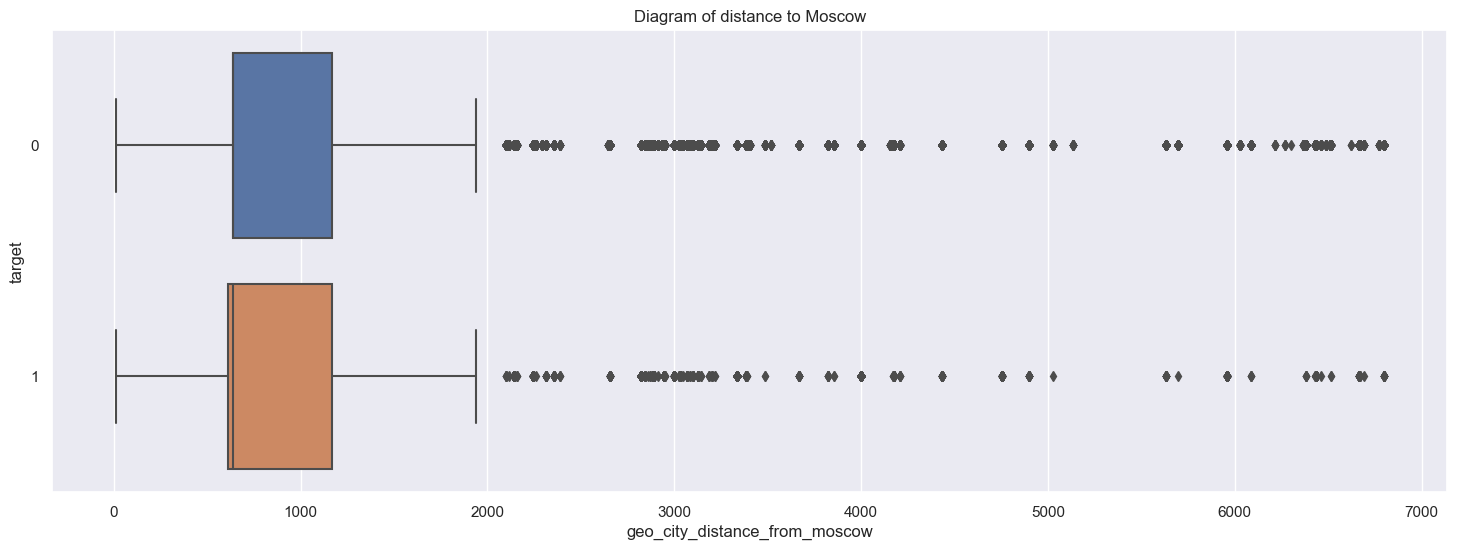

In [129]:
positive_distances = sessions[sessions['geo_city_distance_from_moscow'] > 0]
sns.boxplot(data=positive_distances, x='geo_city_distance_from_moscow',
             y='target', orient='h')
plt.title('Diagram of distance to Moscow');

Split the distance into categories to evaluate the influence of distance on the target variable - `geo_city_distance_from_moscow_category`.

In [130]:
def get_distance_category(distance: float) -> str:
    """
    Returns the distance category to Moscow.
    """

    if distance == -1: return 'no distance'
    elif distance == 0: return 'moscow'
    elif distance < 100: return '< 100 km'
    elif distance < 500: return '100-500 km'
    elif distance < 1000: return '500-1000 km'
    elif distance < 3000: return '1000-3000 km'
    else: return '>= 3000 km'

sessions['geo_city_distance_from_moscow_category'] = \
     sessions['geo_city_distance_from_moscow'].apply(get_distance_category)

In [131]:
print('Distribution of objects by distance to Moscow:')
target_percentage(sessions, 'geo_city_distance_from_moscow_category', index_name='Distance to Moscow')

Distribution of objects by distance to Moscow:


,Number of objects,Percentage of the total,Percentage of target actions
Distance to Moscow,,,
moscow,805329,43.30%,2.93%
< 100 km,102673,5.52%,2.90%
1000-3000 km,229616,12.34%,2.77%
500-1000 km,421113,22.64%,2.54%
100-500 km,107529,5.78%,2.50%
>= 3000 km,61687,3.32%,2.21%
no distance,132095,7.10%,1.96%


## Feature interactions

### Correlations

Of the numerical features, only those that are formed from `device_screen_resolution` really correlate with each other.

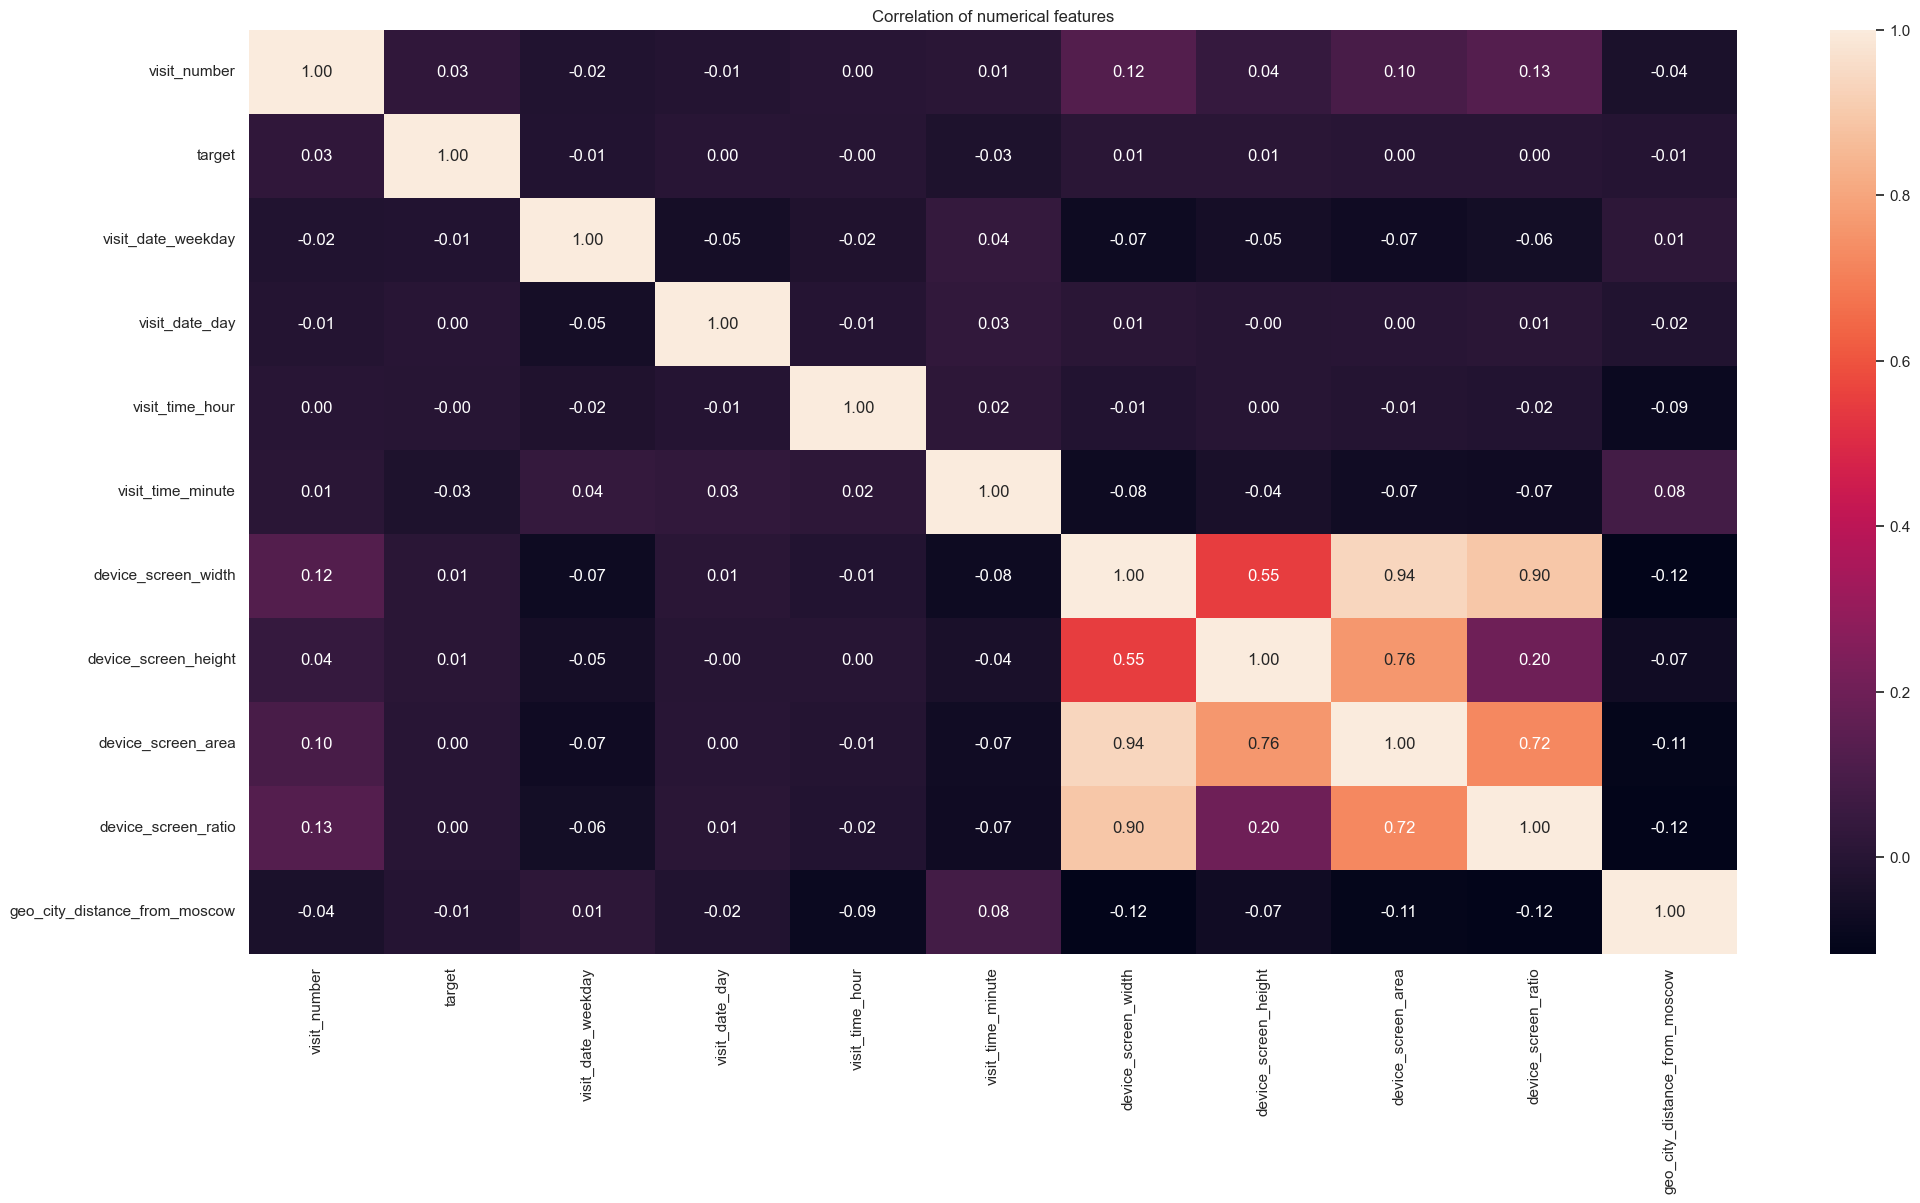

In [132]:
numerical_columns = [
    'visit_number', 'target', 'visit_date_weekday', 'visit_date_day',
    'visit_time_hour', 'visit_time_minute', 'device_screen_width',
    'device_screen_height', 'device_screen_area', 'device_screen_ratio',
    'geo_city_distance_from_moscow']

plt.figure(figsize=(24,12))
sns.heatmap(sessions[numerical_columns].corr(), annot=True, fmt='0.2f')
plt.title('Correlation of numerical features');

### Categorical features

The percentage of targeted actions of organic traffic decreases much faster by the end of the week than the percentage of non-organic traffic.

Organic traffic often performs targeted actions from a computer, while non-organic traffic - from a smartphone.

For the referral type of attraction, the most actions are in the first minute of the hour, possibly due to unscrupulous cheating of referral actions.

In [133]:
def target_ratio(data: pd.Series) -> str:
    """
    Returns the percentage of target actions.
    """
    return as_percent(data.sum() / data.count())

In [134]:
print('Organic traffic target actions by days of the week:')
sessions.pivot_table(
    index='visit_date_weekday', columns='utm_medium_is_organic',
    values='target', aggfunc=[target_ratio, 'count'])

Organic traffic target actions by days of the week:


target_ratio          count        
utm_medium_is_organic        False   True   False    True
visit_date_weekday                                       
0                            2.28%  4.70%  193010  107896
1                            2.23%  4.32%  215645   89485
2                            2.26%  4.22%  185490   73126
3                            2.16%  3.93%  200492   73970
4                            2.01%  3.83%  205818   63001
5                            2.20%  3.34%  174327   52070
6                            2.24%  3.10%  169601   56111

In [135]:
print('Organic traffic target actions by device:')
sessions.pivot_table(
    index='utm_medium_is_organic', columns='device_category',
    values='target', aggfunc=[target_ratio, 'count'])

Organic traffic target actions by device:


target_ratio                 count                
device_category            desktop mobile tablet desktop   mobile tablet
utm_medium_is_organic                                                   
False                        1.70%  2.28%  1.82%  194791  1136846  12746
True                         4.76%  3.68%  3.42%  172072   338025   5562

In [136]:
print('Targeted actions for different types of attraction in the first minute of the hour:')
sessions.pivot_table(
    index='utm_medium_frequent', columns='visit_time_minute_is_zero',
    values='target', aggfunc=[target_ratio, 'count'])

Targeted actions for different types of attraction in the first minute of the hour:


target_ratio          count        
visit_time_minute_is_zero        False   True   False    True
utm_medium_frequent                                          
(none)                           2.23%  3.87%   67374  233201
banner                           2.16%  3.51%  315462  236810
cpc                              2.41%  2.08%  148645  286149
cpm                              0.96%  1.11%  113909  128174
rare_other                       1.79%  3.30%   95596   82672
referral                         2.59%  6.24%   35723  116327

## Data inference


The target variable is unevenly distributed. Only 2.7% of sessions ended with a targeted action.
This will need to be taken into account when splitting the data into training and test sets, as well as when choosing metrics for evaluating models.

+ A larger percentage of targeted actions is observed in sessions during the daytime and in the first half of the week.
+ It seems that the more times a user visits the site, the sooner he will take the target action.
+ Users with organic traffic were more likely to take targeted actions.
+ At the zero minute of every hour, a large number of targeted actions were performed, but this is more like algorithms.
+ Users who come from social networks are less likely to perform targeted actions.
+ More targeted actions are performed from the computer. This is even more noticeable for organic traffic.
+ Most targeted actions are performed by users from Moscow or the Moscow region.
+ Of the numerical features, only derivatives of the screen resolution correlate with each other.
+ The percentage of targeted actions of organic traffic is noticeably reduced by the end of the week, unlike non-organic traffic.

Not all signs can be used directly:
+ the `session_id` column will be used as an index of the final dataset, and in fact will not participate in training;
+ `client_id` is inconvenient to use, so this attribute will simply be removed;
+ `visit_date` and `visit_time` will not be used directly, but additional features will be obtained from them, such as: the hour of the visit, the day of the week, whether the day is a day off, etc.;
+ `device_screen_resolution` cannot be used directly, but additional attributes can be obtained from it: width, height, area and screen ratio;
+ too many spaces in `device_model`, will not be used;
+ there are a lot of outliers in the numerical columns, they will need to be processed;
+ most categorical variables have a very large number of unique values with a small number of repetitions, so rare values will be replaced with 'rare_other' to reduce the size of the dataset after one-hot encoding;
+ additionally, you can get derived features, such as: attracted from social networks `utm_social_media_source`, organic traffic `utm_organic_medium`, location of a city in the Moscow region `geo_moscow_region`, user from a large city `geo_big_city` and distance to Moscow `geo_city_distance_from_moscow`.